# **Part B : News Article Classification**

This project focused on classifying news articles into their respective categories using Natural Language Processing (NLP) and Machine Learning models. The dataset contained labeled news articles across multiple domains such as Politics, Sports, Entertainment, Wellness, and others.






In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
warnings.filterwarnings('ignore')
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Load and Explore the Dataset**

In [52]:
df = pd.read_excel('data_news.xlsx')
print("Data Shape:", df.shape)
df.head()

Data Shape: (50000, 5)


,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [53]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  49994 non-null  object
 4   keywords           47294 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


,0
category,0
headline,0
links,0
short_description,6
keywords,2706


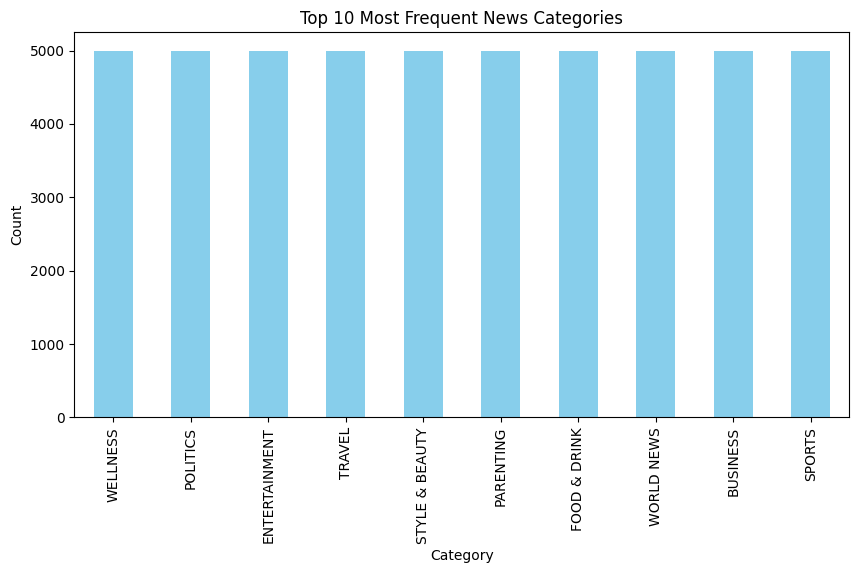

In [54]:
plt.figure(figsize=(10,5))
df['category'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequent News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### Pie Chart – Category Distribution
The following chart shows how the dataset is divided among the most frequent categories.  
This helps in checking whether the dataset is balanced across news topics.


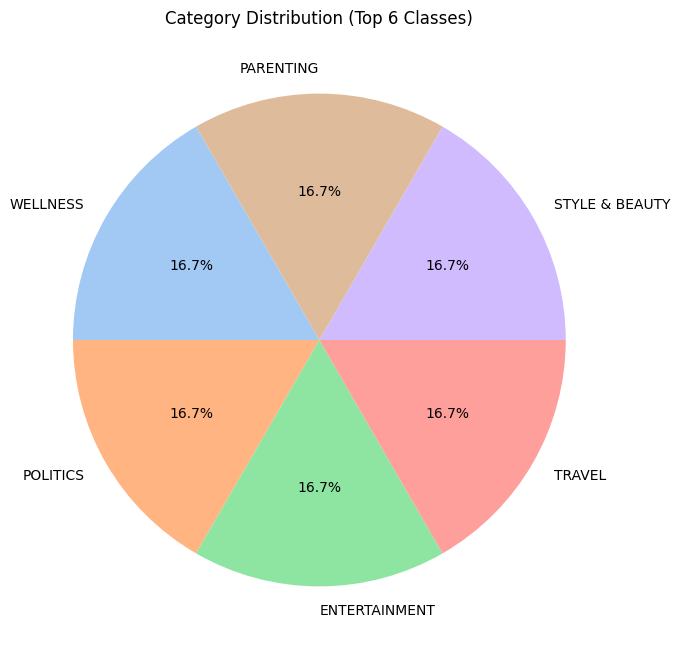

In [55]:
plt.figure(figsize=(8,8))
category_counts = df['category'].value_counts()
plt.pie(category_counts.head(6), labels=category_counts.head(6).index, autopct='%1.1f%%', startangle=120, colors=sns.color_palette('pastel'))
plt.title('Category Distribution (Top 6 Classes)')
plt.show()

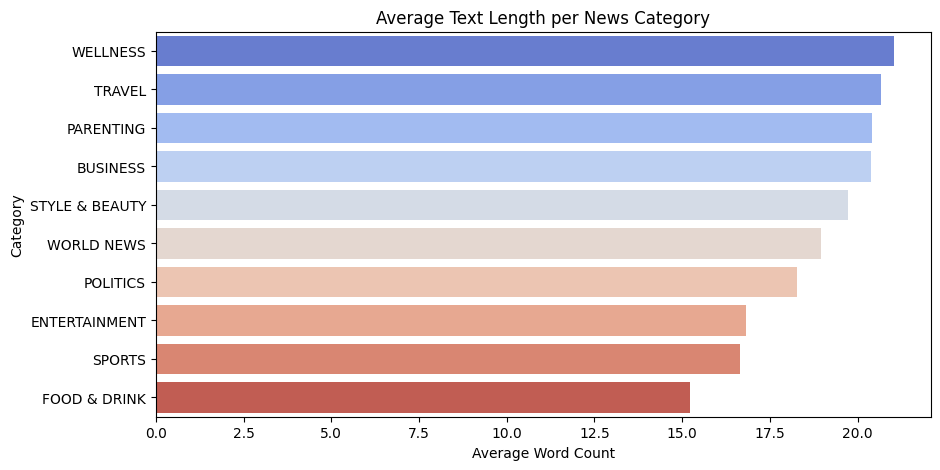

In [62]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
avg_length = df.groupby('category')['text_length'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=avg_length.values, y=avg_length.index, palette='coolwarm')
plt.title('Average Text Length per News Category')
plt.xlabel('Average Word Count')
plt.ylabel('Category')
plt.show()

### Average Text Length per Category
Some categories contain longer descriptions, indicating more detailed reporting.  
This plot provides insight into text variation across different news topics.


### Data Preparation
The raw text data was cleaned by:
- Converting all text to lowercase  
- Removing punctuation, numbers, and special characters  
- Eliminating stopwords  
- Lemmatizing each token to its root form  

After cleaning, a new column `tokens` was created to measure the number of words per article, and very short entries (less than 3 words) were removed to improve data quality.

# **Data Cleaning and Preprocessing**

In [65]:
df = pd.read_excel('data_news.xlsx')
df['text'] = df.get('headline', '').fillna('') + ' ' + df.get('short_description', '').fillna('')
df = df[['text', 'category']].dropna().reset_index(drop=True)
print("Data shape:", df.shape)
print(df['category'].value_counts().head())

Data shape: (50000, 2)
category
WELLNESS          5000
POLITICS          5000
ENTERTAINMENT     5000
TRAVEL            5000
STYLE & BEAUTY    5000
Name: count, dtype: int64


In [73]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [lemm.lemmatize(w) for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)
df['tokens'] = df['clean_text'].apply(lambda x: len(x.split()))
print(df['tokens'].describe())

count    50000.000000
mean        18.810240
std          6.831205
min          2.000000
25%         14.000000
50%         18.000000
75%         22.000000
max        132.000000
Name: tokens, dtype: float64


In [74]:
before = len(df)
df = df[df['tokens'] >= 3]
print(f"Removed {before - len(df)} short texts. Remaining:", len(df))

Removed 1 short texts. Remaining: 49999


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print("Train size:", len(X_train_text), "Test size:", len(X_test_text))
print("Classes:", list(le.classes_))

Train size: 39999 Test size: 10000
Classes: ['BUSINESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'PARENTING', 'POLITICS', 'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS', 'WORLD NEWS']


# **Exploratory Data Analysis (EDA)**

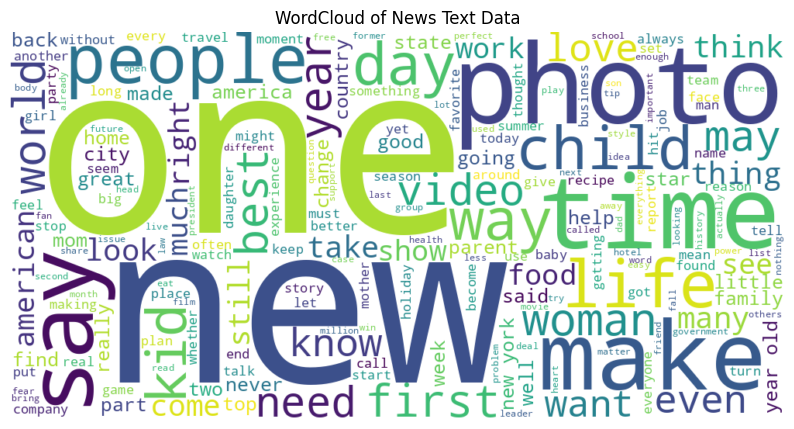

In [77]:
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(' '.join(df['clean_text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of News Text Data')
plt.show()

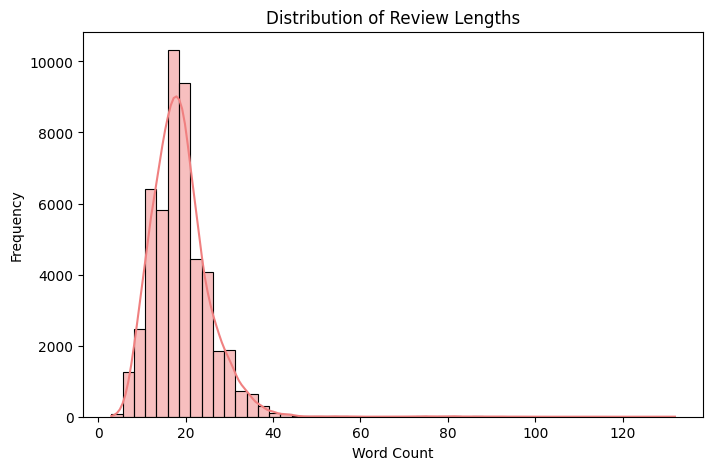

In [78]:
text_length = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(text_length, bins=50, color='lightcoral', kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# **Feature Extraction using TF-IDF**

Text data was transformed into numerical format using **TF-IDF (Term Frequency–Inverse Document Frequency)**.  
Bigram and unigram features were considered (`ngram_range=(1,2)`) to capture both single words and short phrases.  
A vocabulary limit of 20,000 terms was used to balance richness and computational efficiency.

In [79]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8,
    sublinear_tf=True,
    norm='l2'
)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

print("TF-IDF shapes:", X_train.shape, X_test.shape)

TF-IDF shapes: (39999, 20000) (10000, 20000)


# **Models Implemented**
Three models were trained and compared:
1. **Logistic Regression**
2. **Multinomial Naive Bayes**
3. **Linear Support Vector Machine (SVM)**

Each model was evaluated on the same test set using **Accuracy**, **Precision**, **Recall**, and **F1-Score** as metrics.

# **Logistic Regression Model**

In [80]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Weighted F1:", f1_score(y_test, y_pred_lr, average='weighted'))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

Accuracy: 0.8202
Weighted F1: 0.8203199444049023
                precision    recall  f1-score   support

      BUSINESS       0.78      0.79      0.78      1000
 ENTERTAINMENT       0.82      0.81      0.81      1000
  FOOD & DRINK       0.86      0.88      0.87      1000
     PARENTING       0.78      0.79      0.78      1000
      POLITICS       0.80      0.76      0.78      1000
        SPORTS       0.90      0.92      0.91      1000
STYLE & BEAUTY       0.89      0.85      0.87      1000
        TRAVEL       0.82      0.80      0.81      1000
      WELLNESS       0.74      0.79      0.76      1000
    WORLD NEWS       0.83      0.82      0.82      1000

      accuracy                           0.82     10000
     macro avg       0.82      0.82      0.82     10000
  weighted avg       0.82      0.82      0.82     10000



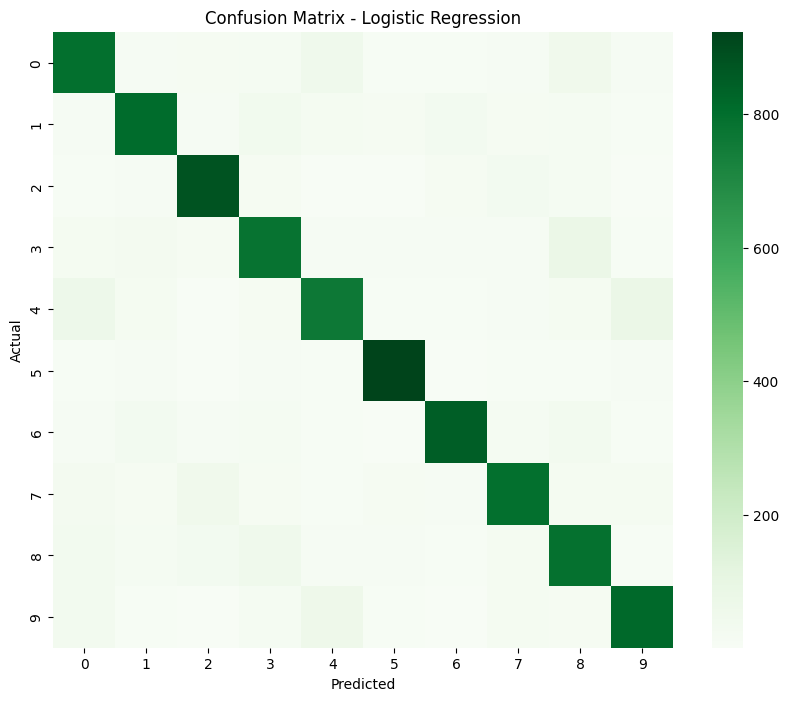

In [81]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(10,8))
sns.heatmap(cm_lr, cmap='Greens', annot=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Naive Bayes Model**

In [82]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Weighted F1:", f1_score(y_test, y_pred_nb, average='weighted'))

Accuracy: 0.8097
Weighted F1: 0.8104293612999234


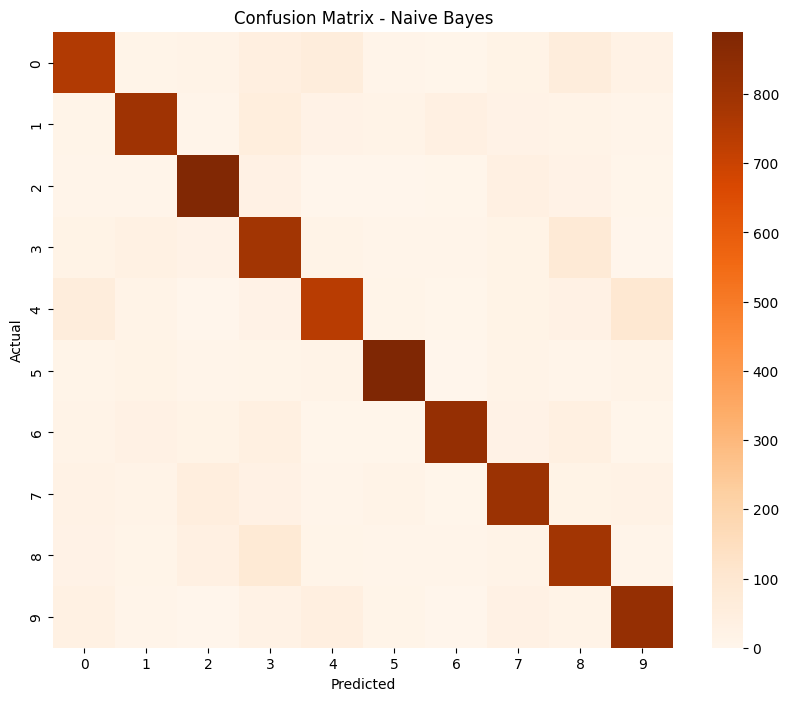

In [83]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(10,8))
sns.heatmap(cm_nb, cmap='Oranges', annot=False)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Support Vector Machine (SVM) Model**

In [84]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('Classification Report - Linear SVM')
print(classification_report(y_test, y_pred_svm))
print('Accuracy:', accuracy_score(y_test, y_pred_svm))

Classification Report - Linear SVM
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1000
           1       0.81      0.80      0.81      1000
           2       0.85      0.88      0.86      1000
           3       0.79      0.79      0.79      1000
           4       0.80      0.76      0.78      1000
           5       0.90      0.94      0.92      1000
           6       0.89      0.86      0.87      1000
           7       0.82      0.80      0.81      1000
           8       0.76      0.78      0.77      1000
           9       0.84      0.80      0.82      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Accuracy: 0.8273


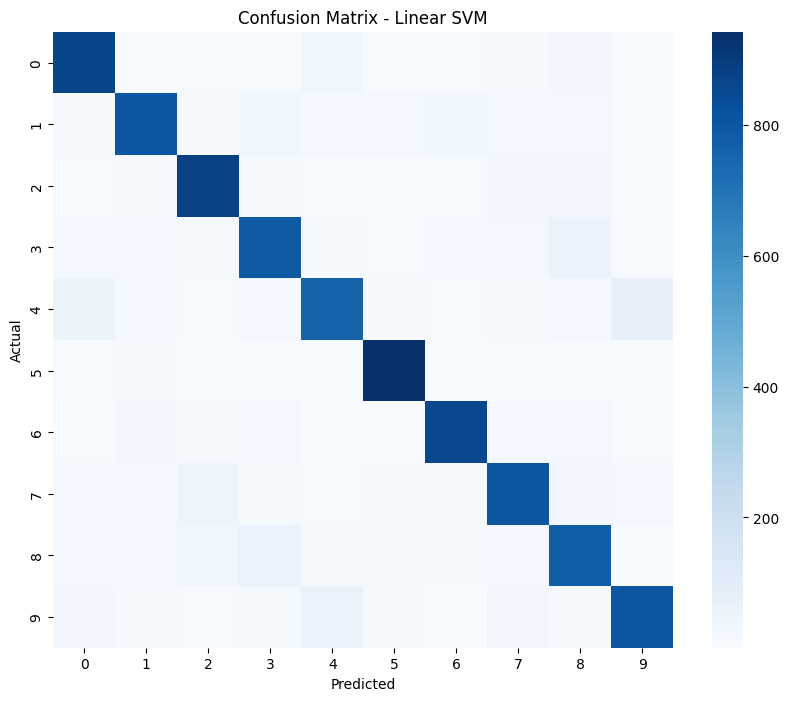

In [85]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10,8))
sns.heatmap(cm_svm, cmap='Blues', annot=False)
plt.title('Confusion Matrix - Linear SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Results & Discussion
- Logistic Regression and Linear SVM performed comparably, achieving the highest accuracy among all models.  
- Naive Bayes produced reasonable results but underperformed slightly, likely due to its stronger assumptions about feature independence.  
- Confusion matrices showed that some overlapping categories (like Wellness and Lifestyle) were harder to separate.  
- TF-IDF proved effective for text representation, capturing essential word patterns and relevance across documents.

The final comparison of model performance (Accuracy & F1-Score) showed clear differences between algorithms and supported the choice of SVM or Logistic Regression for best balance between performance and interpretability.

# **Model Comparison Visualization**

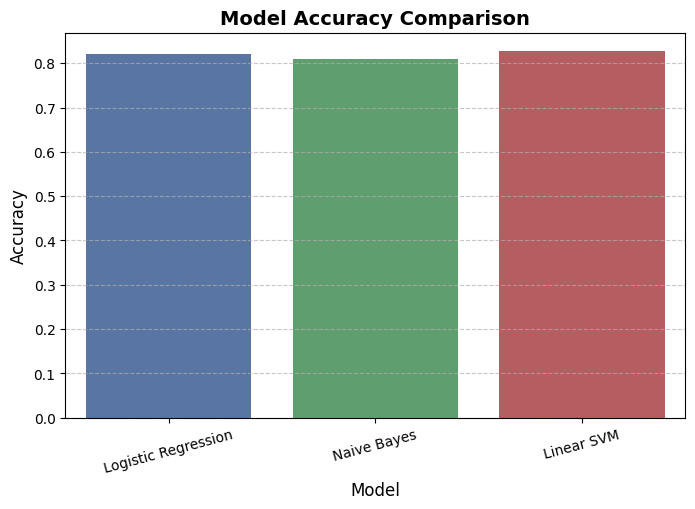

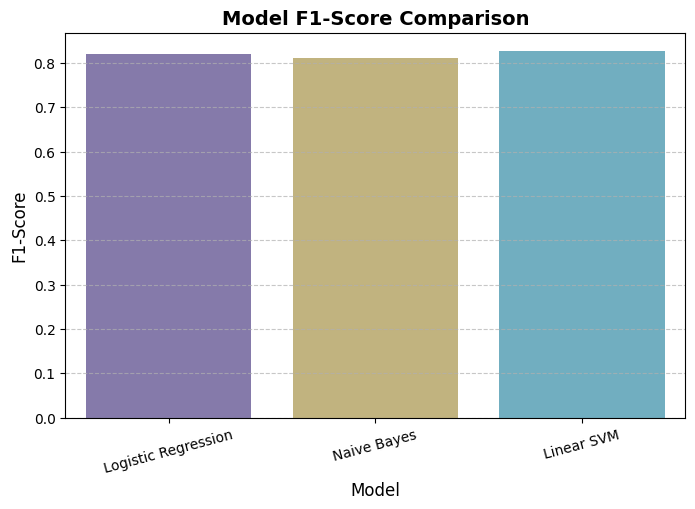

,Model,Accuracy,F1
0,Logistic Regression,0.8202,0.820320
1,Naive Bayes,0.8097,0.810429
2,Linear SVM,0.8273,0.826947


In [90]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Linear SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm)
    ],
    'F1': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_nb, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=results,
            palette=['#4C72B0', '#55A868', '#C44E52'])   # Blue, Green, Red
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='F1', data=results,
            palette=['#8172B2', '#CCB974', '#64B5CD'])
plt.title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

results

### Top Keywords Contributing to Classification
The list below shows the top TF-IDF words most influential in predicting each category according to the SVM model.


In [87]:
feature_names = tfidf.get_feature_names_out()
svm_coefs = svm.coef_
categories = svm.classes_

topn = 10
top_features = {}

for i, cat in enumerate(categories):
    top_indices = np.argsort(svm_coefs[i])[-topn:]
    top_features[cat] = [feature_names[j] for j in top_indices]

for cat, words in top_features.items():
    print(f"\\nTop words for category '{cat}':\\n{', '.join(words)}")

\nTop words for category '0':\nmarketing, customer, ceo, startup, krugman, leadership, company, woman business, wall, business
\nTop words for category '1':\nteaser, movie, actor, box office, jenner, album, netflix, trailer, singer, film
\nTop words for category '2':\nwhiskey, cook, soup, chef, cheese, cooking, food, wine, cocktail, recipe
\nTop words for category '3':\ndaughter, mommy, baby, breastfeeding, mom, child, toddler, parent, parenting, kid
\nTop words for category '4':\njeb, ferguson, congressman, senator, democrat, morning email, fbi, senate, republican, gop
\nTop words for category '5':\nfootball, baseball, player, kobe, fifa, lebron, yankee, nba, espn, nfl
\nTop words for category '6':\nvogue, designer, outfit, makeup, wardrobe, hair, model, style, photo, fashion
\nTop words for category '7':\nflight, traveling, tourist, trip, vacation, airline, tsa, hotel, traveler, travel
\nTop words for category '8':\nnutrition, sleep, fearless, cancer, superfoods, fitness, yoga, medit

# **Save Best Model**

In [88]:
import joblib
joblib.dump(svm, 'news_classifier_svm.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print('Model and vectorizer saved successfully.')

Model and vectorizer saved successfully.


### Conclusion
This study successfully demonstrated multi-class news article classification using standard NLP techniques and classical machine learning models.  
Among all, **Logistic Regression** and **Linear SVM** were the most reliable choices.  
The project provides a complete pipeline from data cleaning to evaluation, serving as a strong foundation for further improvements — such as applying deep learning models (e.g., LSTM or BERT) to boost accuracy in future work.
